In [ ]:
!pip install torchmetrics
!pip install segmentation_models_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16428 sha256=fe96a2526c989bd91d123171d1cc58864b17173b029a0bbe5f2c8e3b3744d7e7
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60945 sha256=624976a778ea72d0e38e194a8bf9220f6f5a3f5249635fc8f96bb2e68c00ba00
  Stored in directory: /root/.cache/pip/wheels/35/cb/a5/8f534c60142835bfc889f9a482e4a67e0b817032d9c6883b64
Successfully built efficientnet-p

In [ ]:
import zipfile
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from sklearn.model_selection import train_test_split
import os
import albumentations as A
import numpy as np
from albumentations.pytorch import ToTensorV2
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
from segmentation_models_pytorch.losses import DiceLoss
import segmentation_models_pytorch as smp

In [ ]:
drive.mount('/content/drive')

zipped_train = '/content/drive/MyDrive/data/train_seg.zip'
z = zipfile.ZipFile(zipped_train, 'r')
z.extractall(path='/content/train')

zipped_test = '/content/drive/MyDrive/data/test_seg.zip'
z = zipfile.ZipFile(zipped_test, 'r')
z.extractall(path='/content/test')


Mounted at /content/drive


In [ ]:
import gc
gc.collect()


0

In [ ]:
transform = A.Compose([
    A.Resize(256, 256),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2(),
])

# Dataset
class SkinCancerDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.images_dir = os.path.join(data_dir, "images")
        self.masks_dir = os.path.join(data_dir, "masks")
        self.id = [os.path.splitext(file)[0] for file in os.listdir(self.images_dir)
                   if os.path.exists(os.path.join(self.masks_dir, os.path.splitext(file)[0] + '.png'))]

    def __len__(self):
        return len(self.id)

    def __getitem__(self, idx):
        image_id = self.id[idx]
        image_path = os.path.join(self.images_dir, image_id + '.jpg')
        mask_path = os.path.join(self.masks_dir, image_id + '.png')
        img = Image.open(image_path)
        mask = Image.open(mask_path)
        img = np.array(img)
        mask = np.array(mask)
        mask[mask == 255.0] = 1.0

        if self.transform:
            augmentation = self.transform(image=img, mask=mask)
            img = augmentation["image"]
            mask = augmentation["mask"]
            mask = torch.unsqueeze(mask, 0)

        return img, mask

# Split dataset
train_dir = '/content/train/train'
dataset = SkinCancerDataset(train_dir, transform=transform)
train_dataset, valid_dataset = train_test_split(dataset, test_size=0.1)


In [ ]:
from segmentation_models_pytorch.utils.metrics import IoU

best_accuracy=0
def save_model_to_drive(model, name):
  pth = os.path.join('/content/drive/MyDrive/Colab Notebooks/models', name)
  torch.save(model, pth)
actual_ep=15

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=1,
)

# DataLoader
bs = 32
train_dataloader = DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
val_dataloader = DataLoader(dataset=valid_dataset, batch_size=bs, shuffle=True)

# Loss and optimizer
lr = 1e-4
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = DiceLoss(mode='binary')

# Training loop
epochs = 5
device = "cuda" if torch.cuda.is_available() else "cpu"

model = model.to(device)
model = torch.load(f'/content/drive/MyDrive/Colab Notebooks/models/resnet34{actual_ep}')

metric = IoU(threshold=0.5)

for epoch in range(epochs):
    model.train()
    total_train_loss = 0.0

    for idx, (image, mask) in enumerate(train_dataloader):
        image = image.float().to(device)
        mask = mask.float().to(device)

        optimizer.zero_grad()

        output = model(image)
        loss = criterion(output, mask)

        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)

    model.eval()
    total_val_loss = 0.0
    total_val_iou = 0.0
    with torch.no_grad():
        for idx, (image, mask) in enumerate(val_dataloader):
            image = image.float().to(device)
            mask = mask.float().to(device)
            output = model(image)
            loss = criterion(output, mask)
            total_val_loss += loss.item()
            total_val_iou += metric(output, mask).item()

        avg_val_loss = total_val_loss / len(val_dataloader)
        avg_val_iou = total_val_iou / len(val_dataloader)

    print(f"Epoch {epoch+1+actual_ep}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val IoU: {avg_val_iou:.4f}")
    # Проверяем точность и сохраняем модель
    if (epoch + 1+actual_ep) % 5 == 0:
        accuracy = avg_val_iou  # Используйте нужную вам метрику для точности
        print(f'Accuracy: {accuracy}')

        # Сохраняем модель, если точность улучшилась
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            no_improvement_count = 0
            save_model_to_drive(model, f'resnet34{epoch + 1+actual_ep}')
            print('Model saved!')
        else:
            no_improvement_count += 1

            # Проверяем условие ранней остановки
            if no_improvement_count >= 5:
                print(f'No improvement for {5} epochs. Training stopped.')
                break

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 84.8MB/s]


Epoch 16: Train Loss: 0.0834, Val Loss: 0.0786, Val IoU: 0.8579
Epoch 17: Train Loss: 0.0841, Val Loss: 0.0775, Val IoU: 0.8598
Epoch 18: Train Loss: 0.0836, Val Loss: 0.0762, Val IoU: 0.8628
Epoch 19: Train Loss: 0.0829, Val Loss: 0.0776, Val IoU: 0.8605
Epoch 20: Train Loss: 0.0838, Val Loss: 0.0765, Val IoU: 0.8631
Accuracy: 0.8630947401890388
Model saved!


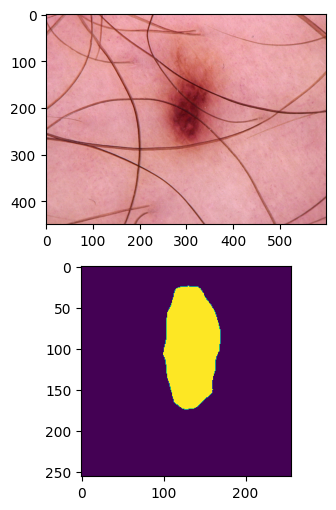

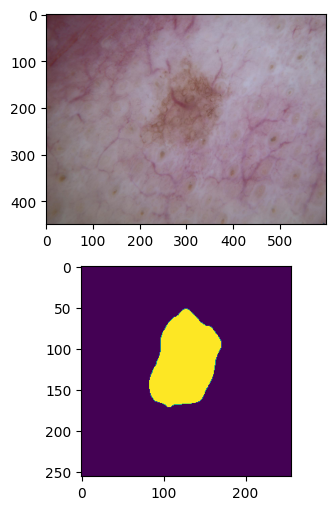

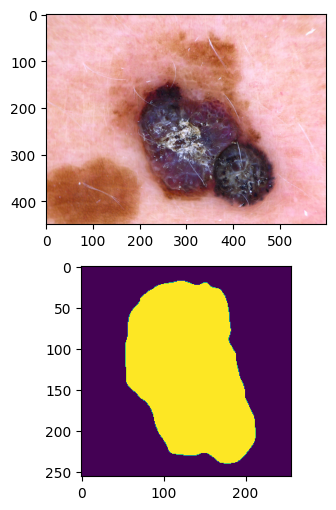

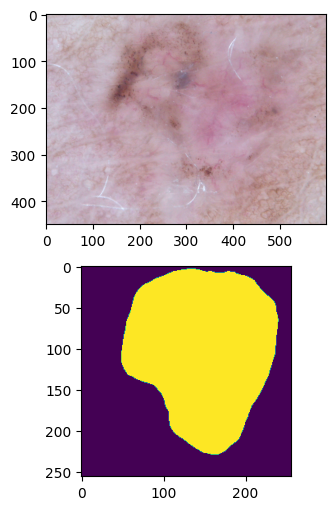

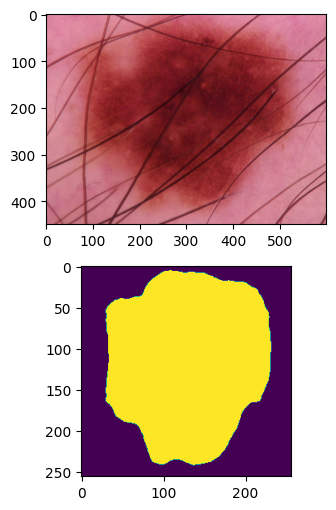

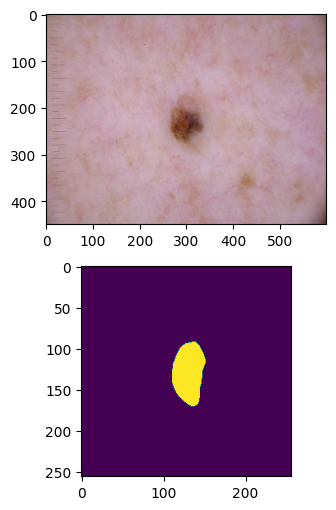

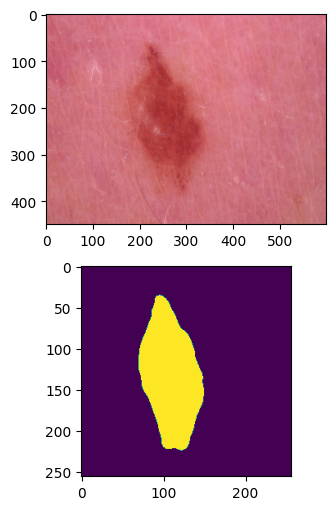

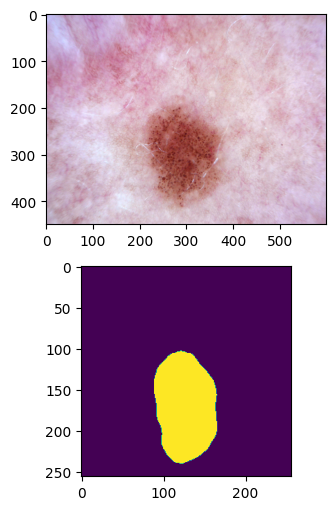

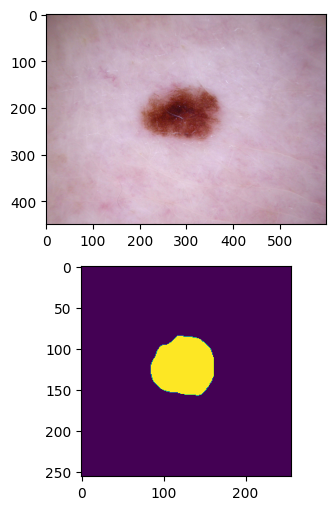

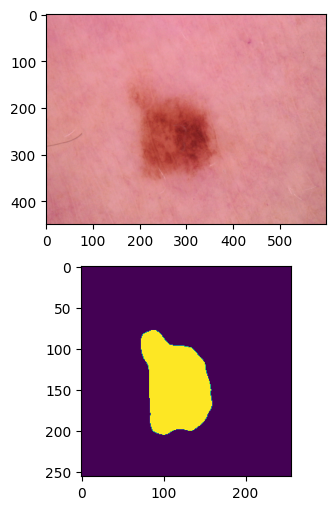

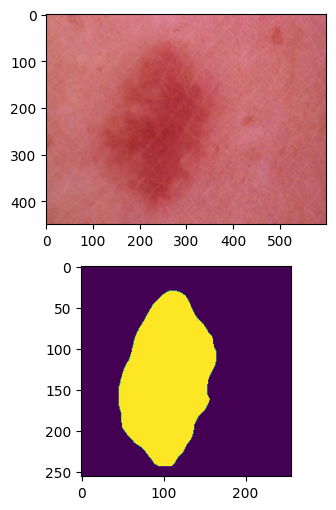

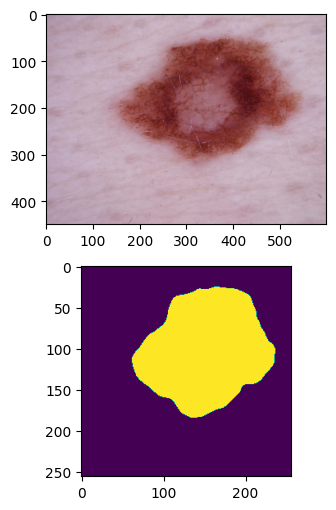

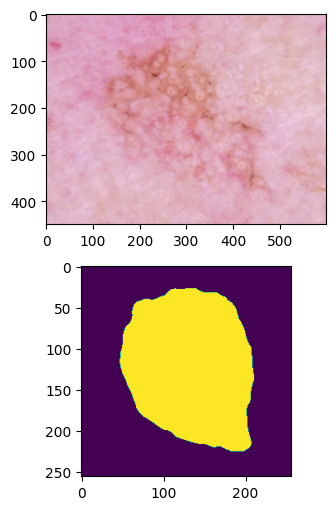

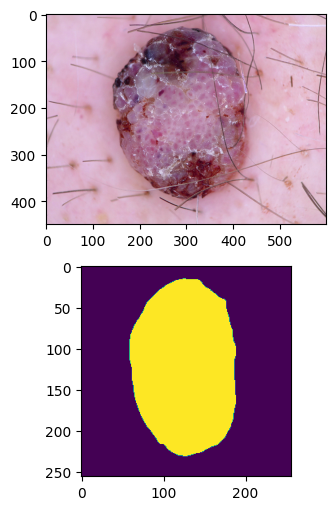

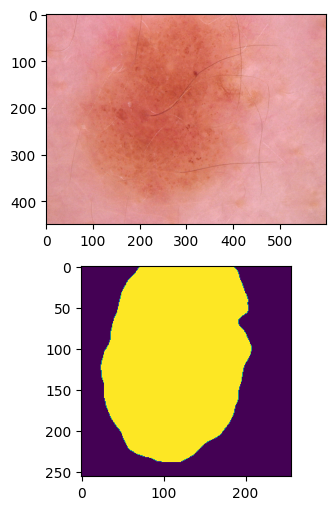

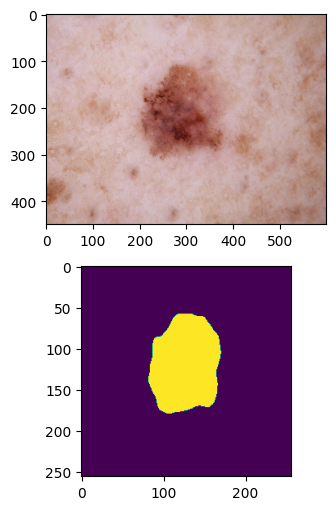

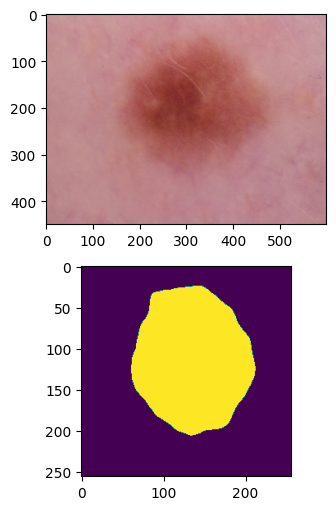

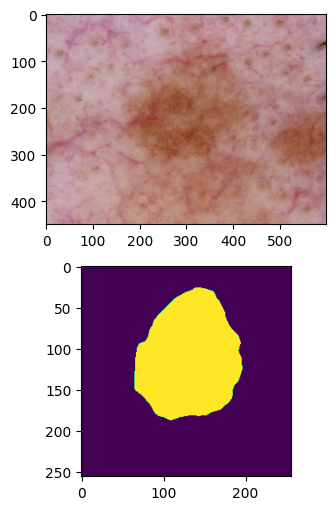

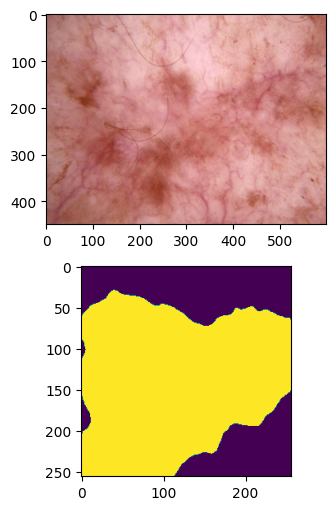

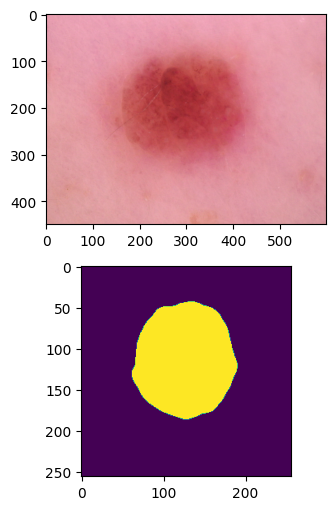

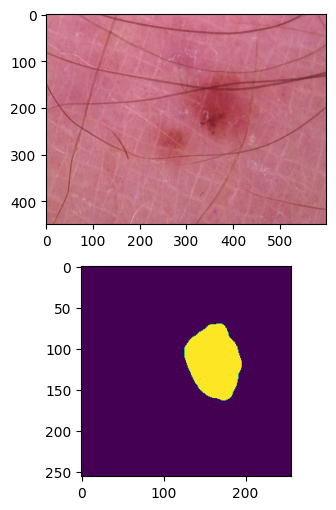

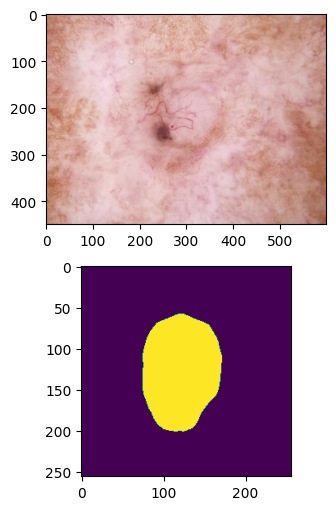

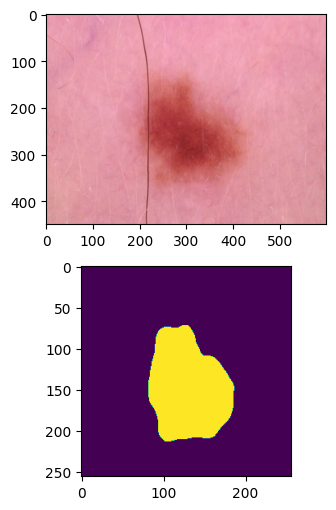

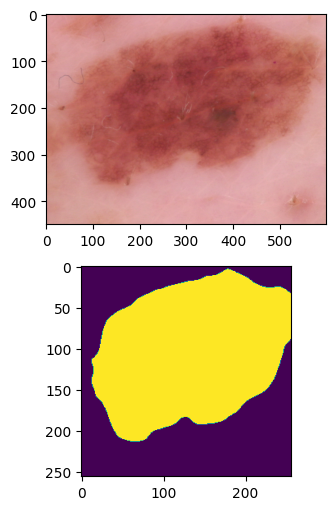

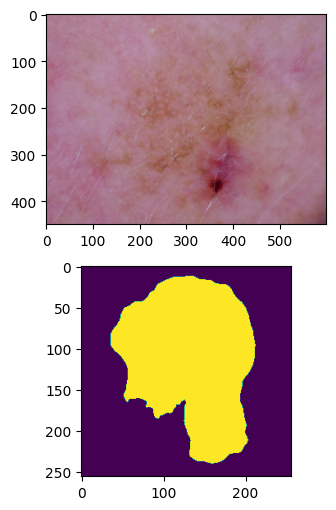

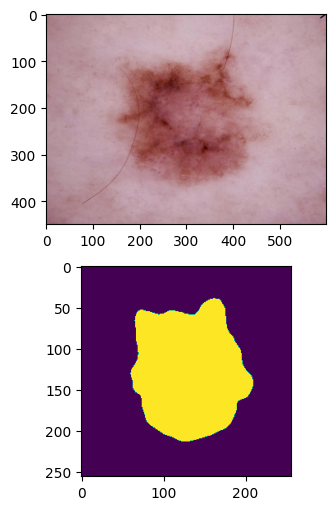

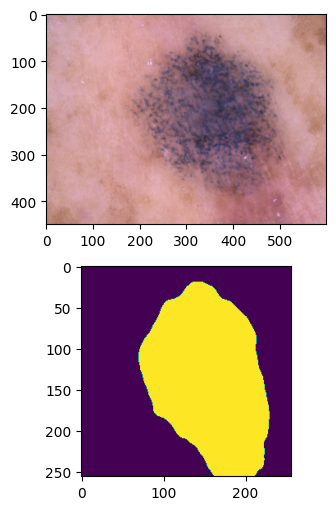

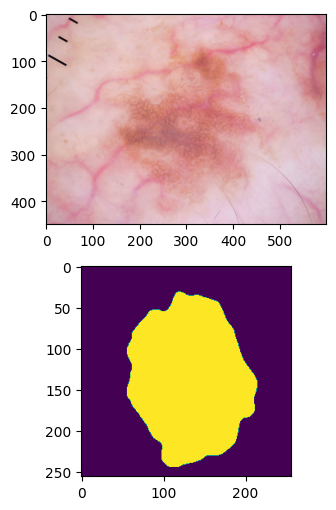

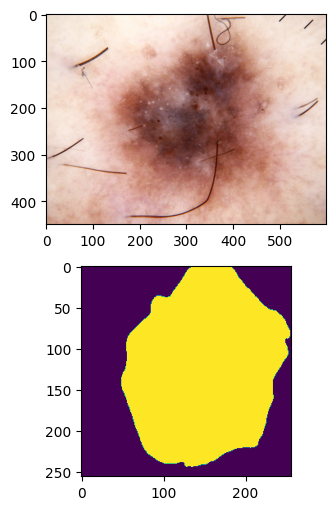

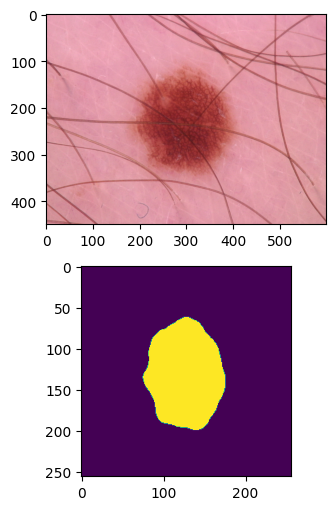

In [ ]:
from PIL import Image
from torchvision.transforms.functional import to_pil_image
import torch
import matplotlib.pyplot as plt

# Test directory
test_dir = "/content/test/"
images_dir = os.path.join(test_dir, "images")
masks_dir = os.path.join(test_dir, "masks")

# Create masks directory if not exists
os.makedirs(masks_dir, exist_ok=True)

# Transformation
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Get list of image filenames
image_filenames = os.listdir(images_dir)

# Process images and save masks
with torch.no_grad():
    for image_filename in image_filenames:
        # Load and preprocess image
        image_path = os.path.join(images_dir, image_filename)
        img = Image.open(image_path).convert('RGB')
        img = transform(img).unsqueeze(0).to(device)

        # Generate predicted mask
        predicted_mask = model(img)
        predicted_mask = torch.sigmoid(predicted_mask)
        predicted_mask = (predicted_mask > 0.5).float()
        predicted_mask = to_pil_image(predicted_mask.squeeze().cpu())

        # Save predicted mask
        mask_filename = os.path.splitext(image_filename)[0] + '.png'
        mask_path = os.path.join(masks_dir, mask_filename)
        predicted_mask.save(mask_path)

# Display a subset of images with their masks
valid_image_files = [file for file in image_filenames
                     if os.path.exists(os.path.join(masks_dir, os.path.splitext(file)[0] + '.png'))]

selected_images = valid_image_files[:30]

for image_filename in selected_images:
    # Load image and mask
    image_path = os.path.join(images_dir, image_filename)
    mask_path = os.path.join(masks_dir, os.path.splitext(image_filename)[0] + '.png')
    image = plt.imread(image_path)
    mask = plt.imread(mask_path)

    # Display images and masks
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 6))
    ax1.imshow(image)
    ax2.imshow(mask)
    plt.show()

In [ ]:
!zip -r '/content/masks.zip' '/content/test/masks'

  adding: content/test/masks/ (stored 0%)
  adding: content/test/masks/ISIC_0028842.png (deflated 1%)
  adding: content/test/masks/ISIC_0025157.png (deflated 2%)
  adding: content/test/masks/ISIC_0032581.png (deflated 2%)
  adding: content/test/masks/ISIC_0033047.png (deflated 1%)
  adding: content/test/masks/ISIC_0025854.png (deflated 2%)
  adding: content/test/masks/ISIC_0026980.png (deflated 1%)
  adding: content/test/masks/ISIC_0029072.png (deflated 10%)
  adding: content/test/masks/ISIC_0031694.png (deflated 4%)
  adding: content/test/masks/ISIC_0029156.png (deflated 2%)
  adding: content/test/masks/ISIC_0029908.png (deflated 3%)
  adding: content/test/masks/ISIC_0029277.png (deflated 2%)
  adding: content/test/masks/ISIC_0032658.png (deflated 1%)
  adding: content/test/masks/ISIC_0033324.png (deflated 2%)
  adding: content/test/masks/ISIC_0028414.png (stored 0%)
  adding: content/test/masks/ISIC_0025113.png (deflated 1%)
  adding: content/test/masks/ISIC_0028480.png (deflated 6%)